# 🎯 P1C3 : Le Pseudo-Labeling, ou l'art de faire confiance à son modèle (avec modération)

Bienvenue dans ce premier chapitre pratique ! Aujourd'hui, on s'attaque à un classique de l'apprentissage semi-supervisé : le **pseudo-labeling**. L'idée ? Si un modèle est suffisamment sûr de sa prédiction sur une image non étiquetée, pourquoi ne pas lui faire confiance et utiliser cette prédiction comme une "vraie" étiquette ?

> C'est un peu comme demander à un élève de corriger ses propres copies. Risqué, mais si on le guide bien, ça peut marcher !

**Objectifs du jour :**
1. Entraîner un premier modèle sur très peu de données.
2. Utiliser ce modèle pour générer des pseudo-labels sur des données non étiquetées.
3. Implémenter la boucle de pseudo-labeling pour ré-entraîner le modèle.
4. Comprendre l'importance du **seuil de confiance** et de la **calibration**.

## 1. Préparation de l'environnement et des données

On commence par les bases : importer les librairies et charger notre dataset, `DermaMNIST`. C'est un jeu de données d'images de lésions cutanées. Notre mission : les classifier correctement, même avec une poignée d'étiquettes.

DermaMNIST fait partie de la famille des datasets **MedMNIST**, une collection standardisée de datasets d'images médicales, tous au format 28x28 et organisés de manière similaire aux célèbres datasets MNIST. L'objectif de MedMNIST est de faciliter la recherche et la comparaison de modèles d'apprentissage automatique sur des tâches médicales.

Le dataset DermaMNIST est basé sur le HAM10000, une large collection d'images de dermatoscopie. Il contient des images de 7 classes différentes de lésions cutanées. Son intérêt pédagogique est majeur : il permet d'aborder des problèmes de classification d'images médicales avec un dataset de taille raisonnable, tout en simulant des scénarios de faible quantité de données étiquetées, parfait pour explorer des techniques comme le pseudo-labeling.

Les 7 classes de lésions cutanées sont :

    0: actinic keratoses and intraepithelial carcinoma
    1: basal cell carcinoma
    2: benign keratosis-like lesions
    3: dermatofibroma
    4: melanoma
    5: melanocytic nevi
    6: vascular lesions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision import transforms
import torchvision.models as models
import medmnist
from medmnist import INFO, Evaluator
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# Pour la reproductibilité, parce qu'on est des gens sérieux
torch.manual_seed(42)
np.random.seed(42)

### 📦 Chargement du dataset DermaMNIST

La librairie `medmnist` nous simplifie la vie. On télécharge les données et on les prépare.

In [2]:
# Nom du dataset à charger
data_flag = 'dermamnist'
# Récupère les informations spécifiques à ce dataset depuis medmnist
info = INFO[data_flag]

# Ajout de prints pour mieux comprendre le dataset
print(f"Dataset chargé : {data_flag}")

# Extrait le type de tâche (classification, régression, etc.)
task = info['task']
print(f"Type de tâche : {task}")

# Extrait le nombre de canaux des images (3 pour RGB, 1 pour niveaux de gris)
n_channels = info['n_channels']
print(f"Nombre de canaux : {n_channels}")

# Extrait le nombre de classes pour la classification
n_classes = len(info['label'])
print(f"Nombre de classes : {n_classes}")

# Récupère la classe Python spécifique pour ce dataset
DataClass = getattr(medmnist, info['python_class'])

# Transformations: on sépare train/test et on ajoute des augmentations légères pour mieux généraliser
# Normalisation explicite 3 canaux
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Charge les datasets d'entraînement et de test
train_dataset = DataClass(split='train', transform=transform_train, download=True)
test_dataset = DataClass(split='test', transform=transform_test, download=True)

print(f"Taille du jeu d'entraînement : {len(train_dataset)}")
print(f"Taille du jeu de test : {len(test_dataset)}")

Dataset chargé : dermamnist
Type de tâche : multi-class
Nombre de canaux : 3
Nombre de classes : 7
Taille du jeu d'entraînement : 7007
Taille du jeu de test : 2005


### 🧪 Pourquoi ces transformations ? (Pédagogie)

Nous séparons désormais clairement l'entraînement et le test et ajoutons de **légères augmentations** (flip horizontal, petite rotation, léger jitter de contraste/luminosité) côté train. 

- Objectif: améliorer la généralisation avec seulement 350 images étiquetées.
- Risque maîtrisé: ces augmentations restent plausibles pour DermaMNIST et n’altèrent pas le diagnostic visuel.
- Normalisation: explicite sur **3 canaux** (`mean=[0.5,0.5,0.5]`, `std=[0.5,0.5,0.5]`) pour clarifier l’intention.

Attendez-vous à de légers gains de stabilité/robustesse par rapport à l’entraînement sans augmentations.

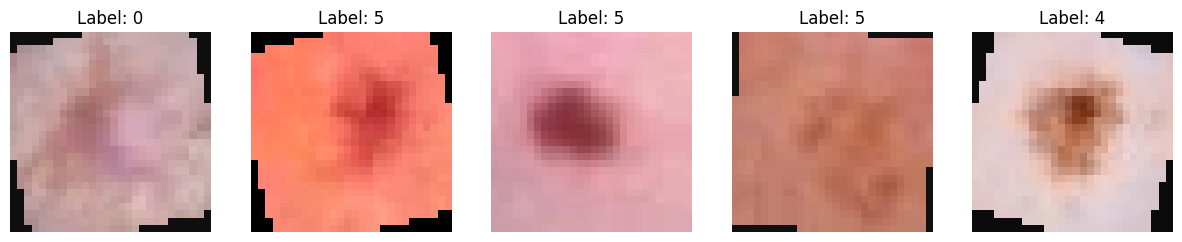

In [3]:
# Visualisation de quelques exemples
num_examples = 5
fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))

for i in range(num_examples):
    # Récupère une image et son label
    image, label = train_dataset[i]
    # L'image est un tensor, on le convertit en numpy array et on le transpose pour l'affichage
    # On dénormalise aussi l'image pour un affichage correct
    img = image.numpy().transpose(1, 2, 0) * 0.5 + 0.5
    axes[i].imshow(img.squeeze(), cmap='gray') # Use cmap='gray' for single channel images if needed
    axes[i].set_title(f"Label: {label.item()}")
    axes[i].axis('off')

plt.show()

### 🧩 Création des jeux de données : Étiqueté vs. Non-étiqueté

C'est ici que la magie du semi-supervisé opère. On va simuler une situation où on a très peu de données étiquetées et un grand volume de données dont on ignore la classe.

On va prendre seulement **50 images par classe** pour l'entraînement étiqueté (350 images au total). Le reste du jeu d'entraînement sera notre vivier de données non-étiquetées.

In [4]:
# On prend tout le set d'entraînement initial
all_indices = list(range(len(train_dataset)))
labels_array = np.array(train_dataset.labels).flatten()

# Sélectionner 50 images par classe
labeled_indices = []
for c in range(n_classes):
    class_indices = np.where(labels_array == c)[0]
    selected = np.random.choice(class_indices, min(50, len(class_indices)), replace=False)
    labeled_indices.extend(selected)

# Les indices non étiquetés sont le reste
unlabeled_indices = list(set(all_indices) - set(labeled_indices))

# Création des Subsets PyTorch
labeled_dataset = Subset(train_dataset, labeled_indices)
unlabeled_dataset = Subset(train_dataset, unlabeled_indices)

print(f"Taille du jeu de données étiqueté : {len(labeled_dataset)}")
print(f"Taille du jeu de données non-étiqueté : {len(unlabeled_dataset)}")
print(f"Taille du jeu de test : {len(test_dataset)}")

# DataLoaders
labeled_loader = DataLoader(dataset=labeled_dataset, batch_size=16, shuffle=True)
unlabeled_loader = DataLoader(dataset=unlabeled_dataset, batch_size=128, shuffle=False) # Pas besoin de shuffle ici
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

Taille du jeu de données étiqueté : 350
Taille du jeu de données non-étiqueté : 6657
Taille du jeu de test : 2005


### 🎓 Objectif pédagogique

Nous allons rendre le notebook plus explicite et mesurable:
- **Suivre des métriques** (AUC, Accuracy, F1 macro) à chaque étape.
- **Visualiser** une matrice de confusion après entraînement.
- **Documenter** nos choix (augmentations, seuils de pseudo‑labels) pour interpréter les résultats—bons ou moins bons.

Distribution des classes dans le 'labeled_dataset' (350 images) :

Classe 0 (actinic keratoses and intraepithelial carcinoma): 50 images
Classe 1 (basal cell carcinoma): 50 images
Classe 2 (benign keratosis-like lesions): 50 images
Classe 3 (dermatofibroma): 50 images
Classe 4 (melanoma): 50 images
Classe 5 (melanocytic nevi): 50 images
Classe 6 (vascular lesions): 50 images


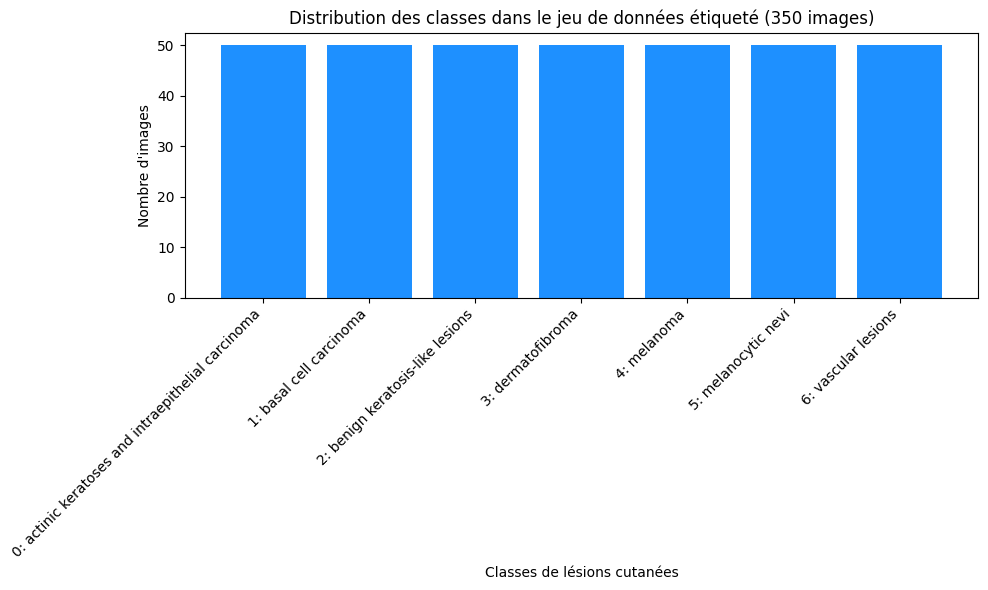

In [5]:
# Les labels du dataset complet sont dans train_dataset.labels
# On récupère les labels correspondant aux indices de notre jeu étiqueté
labels_of_labeled_set = train_dataset.labels[labeled_indices]

# Compter le nombre d'occurrences de chaque classe
class_counts = np.bincount(np.array(labels_of_labeled_set).flatten(), minlength=n_classes)
class_names = [f'{i}: {name}' for i, name in info['label'].items()]

# Afficher les comptes
print("Distribution des classes dans le 'labeled_dataset' (350 images) :\n")
for i, count in enumerate(class_counts):
    # Récupérer le nom complet de la classe
    full_class_name = info['label'][str(i)]
    print(f"Classe {i} ({full_class_name}): {count} images")

# Créer un graphique à barres pour visualiser la distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts, color='dodgerblue')
plt.xlabel('Classes de lésions cutanées')
plt.ylabel("Nombre d'images")
plt.title("Distribution des classes dans le jeu de données étiqueté (350 images)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 📈 Suivi et initialisation des métriques

Nous allons initialiser trois listes globales `metrics_auc`, `metrics_acc`, `metrics_f1` pour tracer l’évolution au fil des itérations. Cela permet de diagnostiquer la dérive potentielle et d’argumenter pédagogiquement nos choix (seuils, marge, quotas).

## 🏗️ 2. Le Modèle de Base (Supervisé)

On va d'abord entraîner un modèle simple (un petit CNN) uniquement sur nos 350 images étiquetées. On s'attend à une performance... modeste. C'est notre point de départ.

In [6]:
# Définition d'un petit CNN (vous pouvez l'améliorer !)
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * 32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

# Définir le device (à mettre au début de votre code si ce n'est pas déjà fait)
device = torch.device("cpu")

# On instancie la loss (sans poids car dataset équilibré)
criterion = nn.CrossEntropyLoss()

# On déplace aussi le modèle sur le device
model = SimpleCNN(in_channels=n_channels, num_classes=n_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### 🔎 Évaluation et visualisation des résultats

Pour interpréter les performances, nous calculons **AUC**, **Accuracy** et **F1 macro** sur le set de test et affichons une **matrice de confusion**. Ces indicateurs se complètent :
- **Accuracy**: proportion de bonnes prédictions (sensible au déséquilibre de classes).
- **F1 macro**: moyenne des F1 par classe, atténue l'effet des classes majoritaires.
- **AUC**: qualité du classement par probabilité (multi‑classe en un‑contre‑tous).

### 📊 Suivi des métriques au fil des itérations

Nous allons suivre **AUC**, **Accuracy** et **F1 macro** à chaque itération de pseudo‑labeling pour rendre visible l'impact de nos choix (seuils, marge, volumes ajoutés). Cette traçabilité aide à expliquer les améliorations… ou les régressions.

### ⚙️ Initialisation des métriques

Nous initialisons des listes globales pour tracer AUC, Accuracy et F1 macro après chaque étape/clé du workflow.

In [7]:
# Listes globales pour tracer les métriques au fil des étapes
metrics_auc, metrics_acc, metrics_f1 = [], [], []


def plot_metrics():
    """Trace l'évolution des AUC/Accuracy/F1 macro si des valeurs sont disponibles."""
    if len(metrics_auc) == 0:
        print("Aucune métrique enregistrée pour le moment.")
        return
    steps = range(1, len(metrics_auc) + 1)
    plt.figure(figsize=(8, 4))
    plt.plot(steps, metrics_auc, label='AUC')
    plt.plot(steps, metrics_acc, label='Accuracy')
    plt.plot(steps, metrics_f1, label='F1 (macro)')
    plt.xlabel('Étape / Itération')
    plt.ylabel('Score')
    plt.title("Évolution des métriques")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [8]:
def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs=10):
    """
    Entraîne et évalue un modèle. Retourne (AUC, ACC, F1).
    Si des listes globales metrics_auc/metrics_acc/metrics_f1 existent, y ajoute les scores.
    """
    device = next(model.parameters()).device

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Évaluation
    model.eval()
    y_true = torch.tensor([]).to(device)
    y_score_logits = torch.tensor([]).to(device)
    y_score_preds = torch.tensor([]).to(device)
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            y_true = torch.cat((y_true, labels), 0)
            y_score_logits = torch.cat((y_score_logits, outputs), 0)
            preds = torch.argmax(outputs, dim=1)
            y_score_preds = torch.cat((y_score_preds, preds), 0)

    y_true = y_true.squeeze().cpu().numpy()
    y_score_logits = y_score_logits.detach().cpu().numpy()
    y_score_preds = y_score_preds.detach().cpu().numpy()

    evaluator = Evaluator(data_flag, 'test')
    auc, acc = evaluator.evaluate(y_score_logits)
    f1 = f1_score(y_true, y_score_preds, average='macro')

    try:
        metrics_auc.append(auc)
        metrics_acc.append(acc)
        metrics_f1.append(f1)
    except NameError:
        pass

    print(f'AUC: {auc:.3f}, Accuracy: {acc:.3f}, F1: {f1:.3f}')
    return (auc, acc, f1)

print("Entraînement du modèle de base sur 350 images étiquetées...")
baseline_metrics = train_and_evaluate(model, labeled_loader, test_loader, optimizer, criterion)


Entraînement du modèle de base sur 350 images étiquetées...
AUC: 0.824, Accuracy: 0.489, F1: 0.234


## 🚀 3. Le Pseudo-Labeling à la rescousse !

Le score de base est probablement... bof. C'est normal !
Maintenant, on va mettre en place la boucle de pseudo-labeling.

**Le principe :**
1. **Prédire** sur les données non étiquetées.
2. **Sélectionner** les prédictions où le modèle est le plus confiant (au-dessus d'un certain `seuil`).
3. **Ajouter** ces prédictions (images + pseudo-labels) au jeu d'entraînement étiqueté.
4. **Ré-entraîner** le modèle sur ce nouveau jeu de données augmenté.
5. Répéter !

Génération des pseudo-labels :
1. Parcourir le `unlabeled_loader`.
2. Obtenir les prédictions du modèle.
3. Appliquer un `softmax` pour avoir des probabilités.
4. Identifier la probabilité maximale (`probs`) et la classe prédite (`preds`) pour chaque image.
5. Ne garder que les images où `probs` est supérieur au `threshold`.
6. Retourner les indices de ces images et leurs pseudo-labels.

In [9]:
def get_pseudo_labels(model, unlabeled_loader, threshold=0.95):
    """Génère des pseudo-labels pour les données où le modèle est confiant."""
    model.eval()
    pseudo_labeled_indices = []
    pseudo_labels = []

    with torch.no_grad():
        for i, (images, _) in enumerate(unlabeled_loader):
            # Déplacer les images sur le même appareil que le modèle (GPU si disponible)
            images = images.to(next(model.parameters()).device)

            # 1. Obtenir les prédictions (logits)
            outputs = model(images)

            # 2. Calculer les probabilités (softmax)
            probabilities = torch.softmax(outputs, dim=1)

            # 3. Obtenir la proba max et la classe prédite
            max_probs, predicted_classes = torch.max(probabilities, dim=1)

            # 4. Filtrer selon le seuil
            confident_mask = max_probs > threshold

            # 5. Récupérer les indices et les labels
            # Les indices dans le DataLoader ne correspondent pas aux indices dans le dataset original
            # Il faut donc calculer les indices réels dans le unlabeled_dataset
            batch_start_index = i * unlabeled_loader.batch_size
            original_indices_in_unlabeled_dataset = torch.arange(batch_start_index, batch_start_index + images.size(0))

            # On utilise les indices originaux dans le unlabeled_dataset pour accéder aux indices dans le train_dataset complet
            original_indices = [unlabeled_loader.dataset.indices[j] for j in original_indices_in_unlabeled_dataset[confident_mask]]

            confident_labels = predicted_classes[confident_mask]


            pseudo_labeled_indices.extend(original_indices)
            pseudo_labels.extend(confident_labels.tolist())

    print(f"Nombre d'images pour lesquelles le modèle est confiant (> {threshold:.2f}) : {len(pseudo_labeled_indices)}")
    return pseudo_labeled_indices, pseudo_labels

### 🔁 La grande boucle de pseudo-labeling

Maintenant, on assemble tout. On va faire plusieurs itérations de pseudo-labeling.

In [10]:
# On réinitialise le modèle et l'optimiseur
ssl_model = SimpleCNN(in_channels=n_channels, num_classes=n_classes).to(device)
ssl_optimizer = torch.optim.Adam(ssl_model.parameters(), lr=0.001)

# On commence avec le jeu de données étiqueté de base
current_labeled_indices = list(labeled_indices)

for iteration in range(5): # 5 itérations de pseudo-labeling
    print(f'--- Itération {iteration+1} ---')

    # On crée le dataset d'entraînement actuel
    iter_dataset = Subset(train_dataset, current_labeled_indices)
    iter_loader = DataLoader(iter_dataset, batch_size=32, shuffle=True)

    # 1. Entraîner le modèle
    print(f'Entraînement sur {len(iter_dataset)} images...')
    pseudo_label_auc, pseudo_label_acc, pseudo_label_f1 = train_and_evaluate(ssl_model, iter_loader, test_loader, ssl_optimizer, criterion, epochs=5)

    # 2. Générer des pseudo-labels
    print('Génération de pseudo-labels...')
    pseudo_indices, pseudo_labels = get_pseudo_labels(ssl_model, unlabeled_loader, threshold=0.9)
    print(f'{len(pseudo_indices)} nouveaux pseudo-labels ajoutés.')

    # 3. Mettre à jour le dataset d'entraînement
    temp_dataset = train_dataset
    for idx, label in zip(pseudo_indices, pseudo_labels):
        # On ne modifie que les labels des images qu'on a pseudo-étiquetées
        if idx not in current_labeled_indices: # Pour ne pas écraser les vrais labels
            temp_dataset.labels[idx] = label
            current_labeled_indices.append(idx)

    if len(pseudo_indices) == 0:
        print("Plus de pseudo-labels trouvés, on arrête là !")
        break

--- Itération 1 ---
Entraînement sur 350 images...
AUC: 0.805, Accuracy: 0.547, F1: 0.290
Génération de pseudo-labels...
Nombre d'images pour lesquelles le modèle est confiant (> 0.90) : 786
786 nouveaux pseudo-labels ajoutés.
--- Itération 2 ---
Entraînement sur 1136 images...
AUC: 0.845, Accuracy: 0.586, F1: 0.308
Génération de pseudo-labels...
Nombre d'images pour lesquelles le modèle est confiant (> 0.90) : 2330
2330 nouveaux pseudo-labels ajoutés.
--- Itération 3 ---
Entraînement sur 2690 images...
AUC: 0.852, Accuracy: 0.585, F1: 0.295
Génération de pseudo-labels...
Nombre d'images pour lesquelles le modèle est confiant (> 0.90) : 2896
2896 nouveaux pseudo-labels ajoutés.
--- Itération 4 ---
Entraînement sur 3410 images...
AUC: 0.846, Accuracy: 0.598, F1: 0.289
Génération de pseudo-labels...
Nombre d'images pour lesquelles le modèle est confiant (> 0.90) : 3430
3430 nouveaux pseudo-labels ajoutés.
--- Itération 5 ---
Entraînement sur 3932 images...
AUC: 0.844, Accuracy: 0.605, F1

In [11]:
# Chemin où sauvegarder le modèle
model_save_path = 'dermamnist_ssl_model.pth'

# On sauvegarde uniquement les poids du modèle (c'est la meilleure pratique)
torch.save(ssl_model.state_dict(), model_save_path)

print(f"Modèle sauvegardé avec succès dans : {model_save_path}")

Modèle sauvegardé avec succès dans : dermamnist_ssl_model.pth


## 🧠 4. Analyse et Questions de Réflexion

A-t-on amélioré le score ? Normalement, oui ! Mais à quel prix ?

**Questions pour aller plus loin :**
1. **L'impact du seuil** : Que se passe-t-il si vous baissez le seuil à 0.8 ? Et si vous l'augmentez à 0.99 ? Un seuil bas risque d'introduire du bruit (mauvais labels), un seuil haut risque de ne sélectionner que les exemples "faciles".
2. **La dérive de confirmation** : Le modèle devient de plus en plus confiant dans ses propres erreurs. Comment pourrait-on limiter ce phénomène ? (Indice : calibration, régularisation...)
3. **Calibration du modèle** : Un modèle bien calibré donne des probabilités qui reflètent sa confiance réelle. Un score de 0.8 devrait signifier "correct dans 80% des cas". Est-ce le cas ici ? Comment le vérifier ? (Indice : ECE, Brier score, diagrammes de fiabilité). C'est un excellent sujet pour le chapitre 7 !

> **Le mot de la fin :** Le pseudo-labeling est une technique simple mais puissante. Son succès dépend entièrement de la qualité des pseudo-labels. Dans les prochains chapitres, on verra des méthodes plus robustes pour s'assurer de ne pas propager les erreurs !

# 🧭 P1C4 : La Propagation de Labels, ou l'art de juger une image par ses voisins 

Bienvenue dans cette nouvelle expérience ! Dans le chapitre précédent sur le pseudo-labeling, on a vu que notre modèle pouvait devenir un peu trop sûr de lui et finir par tourner en rond, en se confortant dans ses propres erreurs. C'est le fameux **biais de confirmation** ! 

> C'est comme ne parler qu'à des gens qui sont d'accord avec vous : on n'apprend plus rien de nouveau.

**Nos objectifs de super-détective :**
1.  **Recruter un expert** : Charger le modèle qu'on a péniblement entraîné au pseudo-labeling pour qu'il nous aide.
2.  **Cartographier le terrain** : Utiliser cet expert pour extraire l'ADN de chaque image (ses *embeddings*).
3.  **Tisser une toile** : Construire un graphe où chaque image est un nœud, connecté à ses plus proches voisins.
4.  **Laisser la magie opérer** : Regarder les étiquettes de nos 350 images connues se propager à travers la toile pour deviner les autres.
5.  **Comparer les résultats** : Est-ce que cette méthode de 'sagesse des foules' est meilleure que de faire confiance à un seul modèle ? Le suspense est à son comble !

## 🧰 1. Préparation du terrain : On reprend (presque) les mêmes !

On commence par importer nos outils et préparer notre jeu de données `DermaMNIST`. On va recréer notre scénario de départ : 350 images étiquetées (50 par classe) et des milliers d'autres qui attendent d'être identifiées.

In [12]:
# Chargement des données
data_flag = 'dermamnist'
info = INFO[data_flag]
n_classes = len(info['label'])
n_channels = info['n_channels']
DataClass = getattr(medmnist, info['python_class'])

# Transformations standard
data_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[.5], std=[.5])])

# On charge le jeu d'entraînement complet et le jeu de test
train_dataset = DataClass(split='train', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)

# On recrée notre situation de départ : 50 images par classe étiquetées, et le reste en attente
all_indices = list(range(len(train_dataset)))
labels_array = np.array(train_dataset.labels).flatten()

# Sélectionner 50 images par classe
labeled_indices = []
for c in range(n_classes):
    class_indices = np.where(labels_array == c)[0]
    selected = np.random.choice(class_indices, min(50, len(class_indices)), replace=False)
    labeled_indices.extend(selected)

# Les indices non étiquetés sont le reste
unlabeled_indices = list(set(all_indices) - set(labeled_indices))

print(f'Taille totale du jeu d\'entraînement : {len(train_dataset)} images')
print(f'Données étiquetées (nos indics ) : {len(labeled_indices)} images')
print(f'Données non-étiquetées (les mystères à résoudre ) : {len(unlabeled_indices)} images')

Taille totale du jeu d'entraînement : 7007 images
Données étiquetées (nos indics ) : 350 images
Données non-étiquetées (les mystères à résoudre ) : 6657 images


---

## 🧑‍🔬 2. Recruter notre expert : le modèle du chapitre précédent

Pour que la propagation de labels fonctionne, on a besoin de 'sentir' la similarité entre les images. Utiliser les pixels bruts serait un désastre ! 

On va donc faire appel à un spécialiste : le `SimpleCNN` qu'on a entraîné dans le notebook `P1C3`. Même s'il n'était pas parfait, il a déjà appris à extraire des caractéristiques pertinentes des images de peau. On va lui demander de nous fournir les **embeddings** : une sorte de résumé numérique, ou d'ADN, pour chaque image.

In [13]:
# On définit l'architecture de notre CNN. 
# ATTENTION : Elle doit être IDENTIQUE à celle du modèle sauvegardé !
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # Pour correspondre exactement au modèle de P1C3
        self.fc = nn.Linear(7 * 7 * 32, num_classes)

    def forward(self, x, return_features=False):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        if return_features:
            return out  # Retourne les features avant la classification (dimension 1568)
        out = self.fc(out)
        return out

model = SimpleCNN(in_channels=n_channels, num_classes=n_classes)
model_path = 'dermamnist_ssl_model.pth'

try:
    state_dict = torch.load(model_path, map_location=device)
    # Les noms de couches correspondent exactement, on charge tout
    model.load_state_dict(state_dict)
    print(f'✅ Modèle chargé depuis : {model_path}')
except FileNotFoundError:
    print(f'🚨 Oups ! Le fichier {model_path} est introuvable.')
    print('Veuillez d\'abord exécuter le notebook P1C3 pour entraîner et sauvegarder le modèle.')
    raise

# On passe le modèle sur le bon appareil et en mode évaluation
model.to(device)
model.eval()

✅ Modèle chargé depuis : dermamnist_ssl_model.pth


SimpleCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=7, bias=True)
)

---

## 🧬 3. Extraction des 'Coordonnées GPS' (Embeddings) 

Maintenant que notre expert est prêt, on va le faire passer sur **toutes** les images de notre jeu d'entraînement (étiquetées ou non) pour obtenir leurs fameux embeddings. C'est comme créer une carte d'identité pour chaque image.

In [14]:
def get_embeddings(model, dataset, device):
    """Extrait les embeddings d'un dataset en utilisant un modèle."""
    model.eval()
    embeddings = []
    loader = DataLoader(dataset, batch_size=256, shuffle=False, num_workers=2)
    
    with torch.no_grad():
        for images, _ in tqdm(loader, desc='Extraction des embeddings'):
            images = images.to(device)
            feats = model(images, return_features=True)
            embeddings.append(feats.cpu().numpy())
            
    return np.vstack(embeddings)

# On extrait les embeddings en utilisant notre modèle
all_embeddings = get_embeddings(model, train_dataset, device)

print(f'\nExtraction terminée ! On a obtenu {all_embeddings.shape[0]} embeddings de dimension {all_embeddings.shape[1]}.')

Extraction des embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.92it/s]


Extraction terminée ! On a obtenu 7007 embeddings de dimension 1568.


---

## 📣 4. La Propagation des Rumeurs (de Labels) 

C'est le moment que vous attendiez tous ! On va utiliser l'algorithme `LabelSpreading` de scikit-learn.

Comment ça marche ?
1. Il prend tous nos embeddings et construit un graphe de similarité (notre fameuse toile ).
2. On lui donne les 350 étiquettes qu'on connaît. Pour les autres, on met une étiquette spéciale : `-1` (qui veut dire 'Je ne sais pas').
3. L'algorithme va alors 'propager' l'influence des étiquettes connues à leurs voisins, puis aux voisins de leurs voisins, jusqu'à ce que chaque image ait une étiquette probable.

C'est un processus démocratique où chaque image est influencée par sa communauté !

In [15]:
# On prépare le tableau des labels pour l'algorithme
labels_for_spreading = np.full(len(train_dataset), -1, dtype=int)
labels_for_spreading[labeled_indices] = labels_array[labeled_indices]

print(f'Verification : {np.sum(labels_for_spreading != -1)} labels sont connus. Parfait !')

# On instancie le modèle LabelSpreading
label_spreading_model = LabelSpreading(kernel='knn', n_neighbors=10, n_jobs=-1)

print('Propagation des labels en cours... C\'est le moment d\'aller prendre un café ')
label_spreading_model.fit(all_embeddings, labels_for_spreading)
print('Propagation terminée ! Voyons ce qu\'on a trouvé.')

# On récupère les labels prédits pour l'ensemble du dataset
predicted_labels = label_spreading_model.transduction_

# On récupère les probabilités prédites pour l'AUC
predicted_probs = label_spreading_model.predict_proba(all_embeddings)

Verification : 350 labels sont connus. Parfait !
Propagation des labels en cours... C'est le moment d'aller prendre un café 
Propagation terminée ! Voyons ce qu'on a trouvé.


---

## ❓ 5. Le Verdict : Alors, ça a marché ? 

Le modèle a rempli tous les trous et a attribué une étiquette à chaque image. Mais est-ce que ces prédictions sont bonnes?

Pour le savoir, on va comparer les étiquettes prédites pour les données *initialement non-étiquetées* avec leurs vraies étiquettes (qu'on avait cachées). C'est l'heure de vérité !

In [16]:
from torch.utils.data import Dataset

# Créer un dataset personnalisé avec les labels propagés
class PropagatedDataset(Dataset):
    def __init__(self, dataset, labels):
        self.dataset = dataset
        self.labels = labels

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]  # Ignore les labels d'origine, img est déjà un tenseur transformé
        label = self.labels[idx]
        return img, label

# Créer le nouveau dataset avec les labels propagés
train_dataset_propagated = PropagatedDataset(train_dataset, predicted_labels)

# Créer un DataLoader pour l'entraînement
train_loader_propagated = DataLoader(train_dataset_propagated, batch_size=32, shuffle=True, num_workers=2)

In [17]:
# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Entraînement du modèle de base sur images étiquetées avec labels propagés...")
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)
metrics = train_and_evaluate(model, train_loader_propagated, test_loader, optimizer, criterion)

print('Entraînement terminé !')

Entraînement du modèle de base sur images étiquetées avec labels propagés...
AUC: 0.505, Accuracy: 0.367, F1: 0.355
Entraînement terminé !


## 🧠 6. Conclusion et Questions pour la suite 

Dans ce run, la propagation de labels sur des embeddings issus d’un petit `SimpleCNN` n’a pas surpassé la boucle de pseudo‑labeling. C’est un résultat fréquent quand les embeddings sont encore « jeunes » et que le graphe n’est pas optimisé. Cela ne remet pas en cause l’intérêt de la méthode : la propagation reste une technique utile pour exploiter la structure globale des données et compléter le pseudo‑labeling.

La propagation de labels est puissante car elle exploite la **structure globale** des données, au lieu de se fier aux prédictions isolées et parfois trop confiantes d'un seul modèle. 

**Mais on peut encore faire mieux ! Voici quelques questions pour ouvrir sur les prochains chapitres :**

1. **La qualité des embeddings** : On a utilisé un petit CNN entraîné sur peu de données. Que se passerait-il si on utilisait un modèle beaucoup plus puissant, comme un **ResNet pré-entraîné sur des millions d'images (ImageNet)**, pour extraire nos embeddings ? La carte serait-elle plus précise ?

2. **Et si on créait de fausses images ?** On manque de données étiquetées. Et si, au lieu de deviner des labels, on demandait à une IA de nous **générer de nouvelles images** de lésions cutanées qui ressemblent aux vraies ? C'est le monde fascinant des **GANs (Generative Adversarial Networks)** que nous explorerons bientôt !

3. **Le meilleur des deux mondes ?** Peut-on combiner le pseudo-labeling et les approches par graphe ? (Indice : oui, et ce sont souvent les méthodes les plus performantes !)


# P1C5 : Les Semi-Supervised GANs, ou l'art de générer pour mieux classer

Bienvenue dans ce chapitre dédié aux Semi-Supervised Generative Adversarial Networks (SGANs) ! Après avoir exploré le pseudo-labeling (qui se fie aux prédictions confiantes du modèle) et la propagation de labels (qui exploite les similarités entre images via des graphes), on passe à une approche plus 'créative' : utiliser des réseaux adversariaux pour générer de nouvelles données et améliorer la classification.

    Imaginez deux agents en compétition : l'un (le générateur) crée de fausses images pour tromper l'autre (le discriminateur), qui doit non seulement détecter les faux, mais aussi classer les vraies images. Cette 'bataille' permet d'apprendre des représentations riches, même avec peu de labels !

Les SGANs étendent les GANs classiques au semi-supervisé : le discriminateur prédit à la fois 'vrai/faux' et la classe pour les images vraies. Cela permet d'utiliser les données non étiquetées pour renforcer l'apprentissage non supervisé (vrai vs faux), et les étiquetées pour la supervision.

Pourquoi SGAN ? Dans les contextes comme DermaMNIST, où les labels sont rares et coûteux (besoin d'experts médicaux), générer de données variées aide le modèle à mieux généraliser sans ajouter de bruit comme dans le pseudo-labeling.

Compréhension clé de la stratégie SGAN :

    Pour les données étiquetées : On corrige le discriminateur (D) pour prédire la bonne classe (0 à 6) avec une perte supervisée, car on connaît la vérité.
    Pour les données non étiquetées : On corrige D pour les classer comme 'réelles' (somme des probabilités des classes 0 à 6 élevée), sans préciser la classe exacte. C'est une correction 'binaire' : si D les place entre 0 et 6, c'est bien ; si en 7 ('faux'), c'est mal, car ce sont des images réelles.
    Pour les images générées (fausses) : On corrige D pour les classer comme 'fausses' (classe 7). Si D les place en 0 à 6, c'est mal ; l'objectif est de maximiser la probabilité de la classe 7.
    Le générateur (G) veut l'inverse : tromper D en faisant passer ses fausses images pour réelles (probabilités élevées en 0 à 6).

Objectifs pédagogiques :

    🧠 Comprendre les GANs et leur adaptation au semi-supervisé.
    🛠️ Implémenter un Générateur et un Discriminateur simples.
    ⚔️ Mettre en place la boucle d'entraînement adversariale.
    📊 Évaluer le Discriminateur comme classificateur et comparer aux méthodes précédentes.
    🎨 Visualiser les images générées pour voir ce que le modèle 'imagine'.

On réutilise notre setup de DermaMNIST avec 350 images étiquetées (50 par classe). Prêts à lancer la démo ?


## 🧰 1. Préparation de l'environnement et des données

On réutilise le code de chargement de DermaMNIST des chapitres précédents. Si vous avez sauté les étapes, exécutez d'abord P1C3 ou P1C4 pour avoir les variables comme `train_dataset`, `labeled_indices`, etc. Ici, on assume qu'elles sont définies.

Rappel de la stratégie SGAN : Les données étiquetées servent à la perte supervisée (correction précise sur la classe connue), les non étiquetées à la perte non supervisée (correction pour 'réel', i.e. classes 0-6), et les générées à renforcer la détection des faux (classe 7).

In [18]:
# Loaders pour SGAN (batch_size plus petit pour stabilité)
sgan_labeled_loader = DataLoader(labeled_dataset, batch_size=64, shuffle=True)
sgan_unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## 🧩 2. Définition des réseaux : Générateur et Discriminateur

Le **Générateur (G)** prend du bruit aléatoire (vecteur de dimension 100) et produit des images 28x28x3.

Le **Discriminateur (D)** est une variante de notre SimpleCNN : il sort `n_classes + 1` logits (les n_classes premières pour les classes réelles, la dernière pour 'faux').

Rappel : Lors de l'entraînement, D sera corrigé différemment selon le type d'image :
- Étiquetées : Prédire la classe exacte (0-6).
- Non étiquetées : Prédire 'réel' (somme probs 0-6 élevée).
- Générées : Prédire 'faux' (prob 7 élevée).

In [19]:
# Dimension du bruit
z_dim = 100

class Generator(nn.Module):
    def __init__(self, z_dim=z_dim, img_channels=3, img_size=28):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, img_size * img_size * img_channels),
            nn.Tanh()  # Sorties entre -1 et 1
        )
        self.img_size = img_size
        self.img_channels = img_channels

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), self.img_channels, self.img_size, self.img_size)
        return img

class Discriminator(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * 32, num_classes + 1)  # +1 pour faux

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Instanciation
G = Generator().to(device)
D = Discriminator(n_channels, n_classes).to(device)

# Optimiseurs
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.002, betas=(0.5, 0.999))

print('Réseaux SGAN prêts pour la démo !')

Réseaux SGAN prêts pour la démo !


## 🔄 3. La boucle d'entraînement adversariale

Lheart des GANs : une boucle où D et G s'affrontent.

Rappel de la stratégie :
- **Pour D sur étiquetées** : Perte supervisée pour prédire la bonne classe (0-6).
- **Pour D sur non étiquetées** : Perte pour prédire 'réel' (somme probs 0-6 élevée).
- **Pour D sur générées** : Perte pour prédire 'faux' (prob 7 élevée).
- **Pour G** : Perte pour tromper D (faire passer les générées pour réelles, somme probs 0-6 élevée).

L'entraînement est alterné. Observez les pertes pour voir l'équilibre.

Entraînement SGAN: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.49s/it]


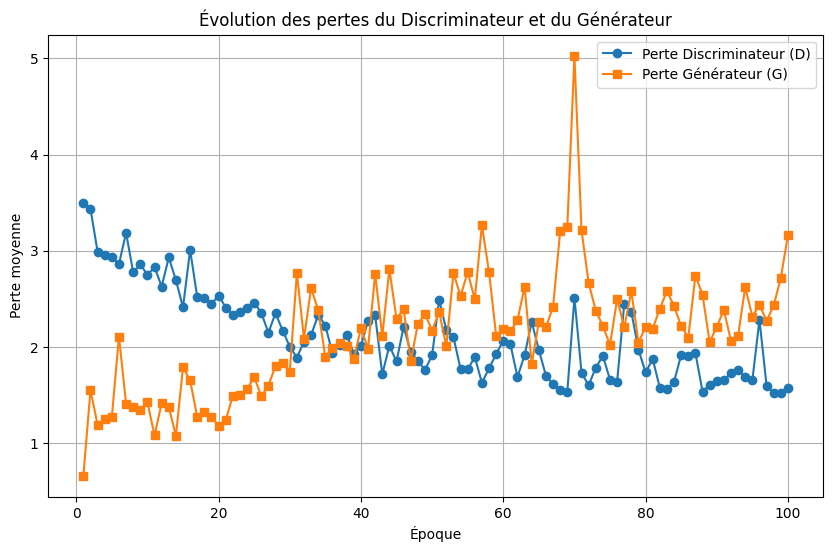

In [20]:
import matplotlib.pyplot as plt

num_epochs = 100  # Ajustez pour la démo (plus = mieux, mais plus long)
supervised_criterion = nn.CrossEntropyLoss()

# Listes pour stocker les pertes moyennes par époque
epoch_d_losses = []
epoch_g_losses = []

for epoch in tqdm(range(num_epochs), desc='Entraînement SGAN'):
    D.train()
    G.train()
    d_losses = []
    g_losses = []

    # Itérateurs pour équilibrer les batches
    labeled_iter = iter(sgan_labeled_loader)
    unlabeled_iter = iter(sgan_unlabeled_loader)

    num_batches = min(len(sgan_labeled_loader), len(sgan_unlabeled_loader))
    for batch_idx in range(num_batches):
        # Données étiquetées
        try:
            labeled_imgs, labels = next(labeled_iter)
        except StopIteration:
            labeled_iter = iter(sgan_labeled_loader)
            labeled_imgs, labels = next(labeled_iter)
        labeled_imgs = labeled_imgs.to(device)
        labels = labels.squeeze().long().to(device)

        # Données non étiquetées
        try:
            unlabeled_imgs, _ = next(unlabeled_iter)
        except StopIteration:
            unlabeled_iter = iter(sgan_unlabeled_loader)
            unlabeled_imgs, _ = next(unlabeled_iter)
        unlabeled_imgs = unlabeled_imgs.to(device)
        batch_size = unlabeled_imgs.size(0)

        # Générer fausses images
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = G(z)

        # --- Entraîner D ---
        d_optimizer.zero_grad()

        # Supervisé sur réelles étiquetées : corriger pour la bonne classe (0-6)
        real_labeled_logits = D(labeled_imgs)
        d_sup_loss = supervised_criterion(real_labeled_logits[:, :n_classes], labels)

        # Non supervisé sur réelles non étiquetées : corriger pour 'réel' (somme probs 0-6 élevée)
        real_unlabeled_logits = D(unlabeled_imgs)
        real_probs = torch.softmax(real_unlabeled_logits, dim=1)[:, :n_classes].sum(1)
        d_real_unsup_loss = -torch.log(real_probs + 1e-10).mean()

        # Non supervisé sur fausses : corriger pour 'faux' (prob 7 élevée)
        fake_logits = D(fake_imgs.detach())
        fake_probs = torch.softmax(fake_logits, dim=1)[:, n_classes]
        d_fake_unsup_loss = -torch.log(fake_probs + 1e-10).mean()

        d_loss = d_sup_loss + d_real_unsup_loss + d_fake_unsup_loss
        d_loss.backward()
        d_optimizer.step()
        d_losses.append(d_loss.item())

        # --- Entraîner G : corriger pour tromper D (somme probs 0-6 élevée pour fausses) ---
        g_optimizer.zero_grad()

        fake_logits_g = D(fake_imgs)
        g_fake_probs = torch.softmax(fake_logits_g, dim=1)[:, :n_classes].sum(1)
        g_loss = -torch.log(g_fake_probs + 1e-10).mean()

        g_loss.backward()
        g_optimizer.step()
        g_losses.append(g_loss.item())

    # Calculer et stocker les pertes moyennes par époque
    epoch_d_losses.append(np.mean(d_losses))
    epoch_g_losses.append(np.mean(g_losses))

# Afficher le graphique des pertes
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_d_losses, label='Perte Discriminateur (D)', marker='o')
plt.plot(range(1, num_epochs + 1), epoch_g_losses, label='Perte Générateur (G)', marker='s')
plt.xlabel('Époque')
plt.ylabel('Perte moyenne')
plt.title('Évolution des pertes du Discriminateur et du Générateur')
plt.legend()
plt.grid(True)
plt.show()

## 📏 4. Évaluation et comparaison

Utilisons le Discriminateur comme classificateur : on prend l'argmax sur les n_classes premières sorties.

Rappel : Grâce à la stratégie, D a été corrigé sur les étiquetées (classes exactes), non étiquetées ('réel' vs 'faux'), et générées (détection des faux). Cela devrait améliorer sa performance en classification.

Comparons avec les baselines des chapitres précédents (remplacez les placeholders par vos résultats réels).

In [21]:
def evaluate_sgan(model, test_loader, n_classes):
    model.eval()
    y_true = []
    y_pred = []
    y_score_probs = []  # Pour stocker les probabilités pour l'AUC

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            logits = model(images)[:, :n_classes]  # Logits pour les classes réelles (0 à n_classes-1)
            probs =nn.functional.softmax(logits, dim=1)  # Convertir en probabilités
            preds = torch.argmax(logits, dim=1)  # Prédictions de classe
            y_true.extend(labels.cpu().numpy().flatten())
            y_pred.extend(preds.cpu().numpy())
            y_score_probs.extend(probs.cpu().numpy())

    # Convertir en arrays NumPy
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score_probs = np.array(y_score_probs)

    # Calculer les métriques
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_score_probs, multi_class='ovr')  # Utiliser probabilités et 'ovr'
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f'Accuracy SGAN: {acc:.3f}, AUC: {auc:.3f}, F1-Score: {f1:.3f}')
    return acc, auc, f1

# Appel de la fonction
sgan_acc, sgan_auc, sgan_f1 = evaluate_sgan(D, test_loader, n_classes)

# Comparaison (remplacez par vos valeurs de P1C3/P1C4)
print('\n--- Comparaison ---')
print(f'Pseudo-Labeling - Acc: {pseudo_label_acc:.3f}, F1: {pseudo_label_f1:.3f}, AUC: {pseudo_label_auc:.3f}')
print(f'Label Propagation - Acc: {metrics[1]:.3f}, F1: {metrics[2]:.3f}, AUC: {metrics[0]:.3f}')
print(f'SGAN - Acc: {sgan_acc:.3f}, F1: {sgan_f1:.3f}, AUC: {sgan_auc:.3f}')

Accuracy SGAN: 0.482, AUC: 0.832, F1-Score: 0.297

--- Comparaison ---
Pseudo-Labeling - Acc: 0.605, F1: 0.301, AUC: 0.844
Label Propagation - Acc: 0.367, F1: 0.355, AUC: 0.505
SGAN - Acc: 0.482, F1: 0.297, AUC: 0.832


## 👀 5. Visualisation des images générées

Voyons ce que le Générateur a appris ! On génère quelques images aléatoires.

Rappel : Ces images sont créées pour tromper D, donc si elles ressemblent à des lésions (et forcent D à les classer en 0-6), G a bien fonctionné. Si D les classe en 7, il détecte les faux efficacement.

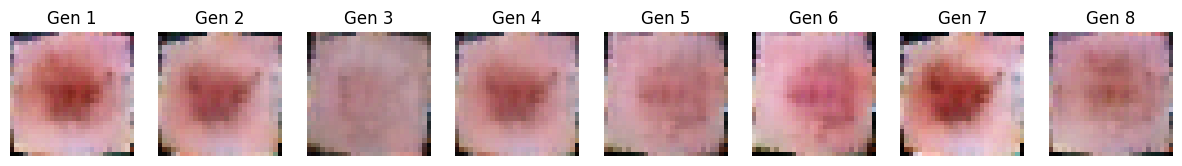

In [22]:
num_gen = 8
z = torch.randn(num_gen, z_dim).to(device)
gen_imgs = G(z).cpu().detach()
gen_imgs = (gen_imgs + 1) / 2  # Dénormaliser [0,1]

fig, axes = plt.subplots(1, num_gen, figsize=(15, 3))
for i in range(num_gen):
    axes[i].imshow(gen_imgs[i].permute(1, 2, 0).numpy())
    axes[i].axis('off')
    axes[i].set_title(f'Gen {i+1}')
plt.show()

## 🧠 6. Conclusion et Questions pour la suite

Les SGAN démontrent comment la génération adversariale peut enrichir l'apprentissage semi-supervisé en créant de la variété. Rappel de la stratégie : Correction précise sur étiquetées (classes 0-6), 'réel' sur non étiquetées (somme 0-6), 'faux' sur générées (classe 7). Le générateur trompe D pour améliorer les deux.

Si les images générées ressemblent à des lésions cutanées, le modèle a capturé des motifs utiles !

**Questions pour réfléchir :**
1. **Améliorations** : Comment rendre le SGAN conditionnel (cSGAN) pour générer par classe ? Utile pour équilibrer les minoritaires ?
2. **Stabilité** : Les GANs sont instables. Testez avec plus d'époques ou WGAN (Wasserstein loss). Qu'observez-vous ?
3. **Hybride** : Combinez SGAN avec pseudo-labeling : utilisez les fausses images comme non étiquetées supplémentaires.

# 🧭 P1C6 : La Régularisation par Cohérence, ou l'art d'être constant avec soi-même

Fini la classification pour aujourd'hui ! On passe à la **segmentation**. Et pour ça, on va utiliser une des techniques les plus puissantes du SSL : la **régularisation par cohérence**. Le principe est d'une simplicité désarmante : un modèle doit donner des prédictions similaires pour la même image, même si celle-ci est vue sous différents angles (augmentations).

> Si vous reconnaissez votre chat qu'il soit à l'endroit, à l'envers ou un peu flou, votre modèle devrait en faire autant !

On va implémenter une architecture populaire qui utilise cette idée : le **Mean Teacher** (le prof moyen). Un modèle 'étudiant' apprend normalement, tandis qu'un modèle 'professeur' (plus stable) le guide. Le professeur n'est que la moyenne des poids passés de l'étudiant.

**Objectifs du jour :**
1. Changer de tâche : passer à la segmentation sur le dataset `Kvasir-SEG`.
2. Mettre en place des pipelines d'augmentations **faibles** et **fortes**.
3. Implémenter le modèle Mean Teacher.
4. Calculer une perte de supervision (sur les données étiquetées) et une perte de cohérence (sur les non-étiquetées).
5. Visualiser les performances via l'évolution des pertes et le Dice Score.

On va utiliser seulement **50 images étiquetées** pour simuler un scénario réaliste où les masques de segmentation sont rares. Prêts pour la démo ?

## 🧰 1. Préparation pour la segmentation

On importe les bibliothèques nécessaires pour la segmentation, notamment des fonctions de perte comme le CrossEntropyLoss (adapté pour la segmentation multiclasse) et la librairie d'augmentation `albumentations` pour créer des transformations faibles et fortes.

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

### 📦 Chargement du dataset

On utilise `Kvasir-SEG`, un dataset de segmentation multi-organes. On sélectionne **50 images étiquetées** pour simuler un scénario semi-supervisé réaliste, où les masques sont coûteux à obtenir.

In [24]:
# Custom Dataset class for Kvasir-SEG
class KvasirSegDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_dir = os.path.join(data_dir, 'images')
        self.mask_dir = os.path.join(data_dir, 'masks')
        self.image_files = sorted([f for f in os.listdir(self.image_dir) if f.endswith('.jpg')])
        self.mask_files = sorted([f for f in os.listdir(self.mask_dir) if f.endswith('.jpg')])
        
        # Verify that images and masks match
        assert len(self.image_files) == len(self.mask_files), "Mismatch between images and masks"
        for img_f, mask_f in zip(self.image_files, self.mask_files):
            assert img_f == mask_f, f"Mismatch: {img_f} != {mask_f}"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        
        # Load image and mask
        image = np.array(Image.open(img_path).convert('RGB'))  # Shape: (H, W, 3)
        mask = np.array(Image.open(mask_path).convert('L'))    # Shape: (H, W)
        
        # Ensure mask is binary (0 or 1)
        mask = (mask > 0).astype(np.uint8)  # Convert to binary (0 for background, 1 for polyp)
        
        # Apply transformations if provided
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']
        
        return image, mask

### 🧪 Augmentations : le bon, la brute et le truand

On définit deux niveaux d'augmentation :
- **Faible (weak)** : pour le `teacher`, avec des transformations légères comme des flips horizontaux.
- **Forte (strong)** : pour le `student`, avec des transformations plus agressives (rotation, flou, cutout) pour le pousser à généraliser.

Un dataset custom gère ces deux pipelines : les données étiquetées reçoivent des augmentations fortes, les non étiquetées reçoivent les deux types.

In [25]:
# Augmentation pipelines with resize
IMG_SIZE = (384, 384)  # Fixed size for Kvasir-SEG
weak_transform = A.Compose([
    A.Resize(height=IMG_SIZE[0], width=IMG_SIZE[1], interpolation=1),  # Resize to 384x384
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # RGB normalization
    ToTensorV2()
])

strong_transform = A.Compose([
    A.Resize(height=IMG_SIZE[0], width=IMG_SIZE[1], interpolation=1),  # Resize to 384x384
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(p=0.3),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(height=IMG_SIZE[0], width=IMG_SIZE[1], interpolation=1),  # Resize to 384x384
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # RGB normalization
    ToTensorV2()
])

# Adapted MeanTeacherDataset for Kvasir-SEG
class MeanTeacherDataset(Dataset):
    def __init__(self, dataset, indices, weak_transform, strong_transform, is_labeled=True):
        self.dataset = torch.utils.data.Subset(dataset, indices)
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform
        self.is_labeled = is_labeled

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, mask = self.dataset[idx]
        img = np.asarray(img, dtype=np.uint8)  # Shape: (H, W, 3) or (3, H, W) if tensor
        mask = np.asarray(mask, dtype=np.uint8)  # Shape: (H, W) or (1, H, W) if tensor
        
        # Ensure mask is binary (0 or 1)
        mask = (mask > 0).astype(np.uint8)

        # Check and reshape image to (H, W, 3)
        if isinstance(img, np.ndarray) and len(img.shape) == 3:
            if img.shape[0] == 3:  # Tensor-like (3, H, W)
                img = np.transpose(img, (1, 2, 0))  # Convert to (H, W, 3)
            elif img.shape[2] != 3:  # Invalid channels
                raise ValueError(f"Image at index {idx} has invalid shape {img.shape}, expected (H, W, 3)")
        else:
            raise ValueError(f"Image at index {idx} has invalid shape {img.shape}, expected (H, W, 3)")

        # Check and reshape mask to (H, W)
        if isinstance(mask, np.ndarray):
            if len(mask.shape) == 3:
                if mask.shape[0] == 1:  # Tensor-like (1, H, W)
                    mask = mask.squeeze(0)  # Convert to (H, W)
                elif mask.shape[2] == 1:  # (H, W, 1)
                    mask = mask.squeeze(2)  # Convert to (H, W)
                else:
                    raise ValueError(f"Mask at index {idx} has invalid shape {mask.shape}, expected (H, W)")
            elif len(mask.shape) != 2:
                raise ValueError(f"Mask at index {idx} has invalid shape {mask.shape}, expected (H, W)")

        # Ensure image and mask have the same H, W
        if img.shape[:2] != mask.shape[:2]:
            img = cv2.resize(img, (IMG_SIZE[1], IMG_SIZE[0]), interpolation=cv2.INTER_LINEAR)
            mask = cv2.resize(mask, (IMG_SIZE[1], IMG_SIZE[0]), interpolation=cv2.INTER_NEAREST)

        # Apply augmentations
        if not self.is_labeled:
            transformed_weak = self.weak_transform(image=img, mask=mask)
            transformed_strong = self.strong_transform(image=img, mask=mask)
            return transformed_weak['image'], transformed_strong['image']
        else:
            transformed = self.strong_transform(image=img, mask=mask)
            return transformed['image'], transformed['mask'].long()

/home/quillaur/jupyter_notebooks/.venv/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [26]:

# Configuration du dataset
data_dir = '/home/quillaur/HDD-1TO/datasets/kvasir-seg/Kvasir-SEG'  # Replace with your dataset path
dataset = KvasirSegDataset(data_dir=data_dir, transform=None)  # No transform initially

# Split for SSL demo: 50 labeled, 100 test, rest unlabeled
train_size = len(dataset)
labeled_size = 50
test_size = 100
unlabeled_size = train_size - labeled_size - test_size
labeled_dataset, test_dataset, unlabeled_dataset = random_split(dataset, [labeled_size, test_size, unlabeled_size])

# Assign transform to test_dataset
test_dataset.dataset.transform = test_transform

# DataLoaders for MeanTeacherDataset
labeled_train_dataset = MeanTeacherDataset(dataset, labeled_dataset.indices, weak_transform, strong_transform, is_labeled=True)
unlabeled_train_dataset = MeanTeacherDataset(dataset, unlabeled_dataset.indices, weak_transform, strong_transform, is_labeled=False)

labeled_loader = DataLoader(labeled_train_dataset, batch_size=4, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_train_dataset, batch_size=16, shuffle=True)

# Print number of labeled, unlabeled, and test samples
print(f"Dataset loaded: {len(dataset)} samples | Labeled: {len(labeled_dataset)} | Unlabeled: {len(unlabeled_dataset)} | Test: {len(test_dataset)}")


Dataset loaded: 1000 samples | Labeled: 50 | Unlabeled: 850 | Test: 100


## 🏗️ 2. Le Modèle (Student & Teacher)

Pour la segmentation, on utilise une architecture de type U-Net simplifiée (pour la démo). On crée **deux instances** : `student` et `teacher`. Le `teacher` est une copie du `student`, mais ses poids sont mis à jour via une moyenne mobile exponentielle (EMA) pour plus de stabilité.

In [27]:
# Device setup: Force CPU
device = torch.device('cpu')
print(f"Using device: {device}")

# Un U-Net très simple pour l'exemple
def simple_unet(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, 16, 3, padding=1), nn.ReLU(inplace=True),
        nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(inplace=True),
        nn.Conv2d(32, 16, 3, padding=1), nn.ReLU(inplace=True),
        nn.Conv2d(16, out_channels, 1)
    )

def create_models(in_channels, out_channels):
    student = simple_unet(in_channels, out_channels).to(device)
    teacher = simple_unet(in_channels, out_channels).to(device)
    
    # Le teacher ne s'entraîne pas par backprop, on gèle ses poids
    for param in teacher.parameters():
        param.detach_()
        
    return student, teacher

# Création des modèles
in_channels = 3  # RGB images for Kvasir-SEG
out_channels = 2  # Binary segmentation (polyp vs. background)
student_model, teacher_model = create_models(in_channels, out_channels)
print('Modèles Student et Teacher prêts pour la démo !')

Using device: cpu
Modèles Student et Teacher prêts pour la démo !


## 🔄 3. La boucle d'entraînement Mean Teacher

Voici le cœur de la démo ! À chaque époque :
1. Le `student` est entraîné sur les **données étiquetées** avec une perte supervisée (CrossEntropyLoss).
2. Les **données non étiquetées** passent par le `teacher` (augmentations faibles) et le `student` (augmentations fortes), et on calcule une **perte de cohérence** (MSE) entre leurs prédictions softmax.
3. La perte totale combine la perte supervisée et la perte de cohérence.
4. Le `teacher` est mis à jour via une moyenne mobile exponentielle (EMA) des poids du `student`.

On affiche les pertes à chaque époque et on trace leur évolution pour voir la progression.

Entraînement Mean Teacher: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:13<00:00, 62.78s/it]


Époque 5/5 - Perte Sup moyenne: 0.4295, Perte Con moyenne: 0.0983


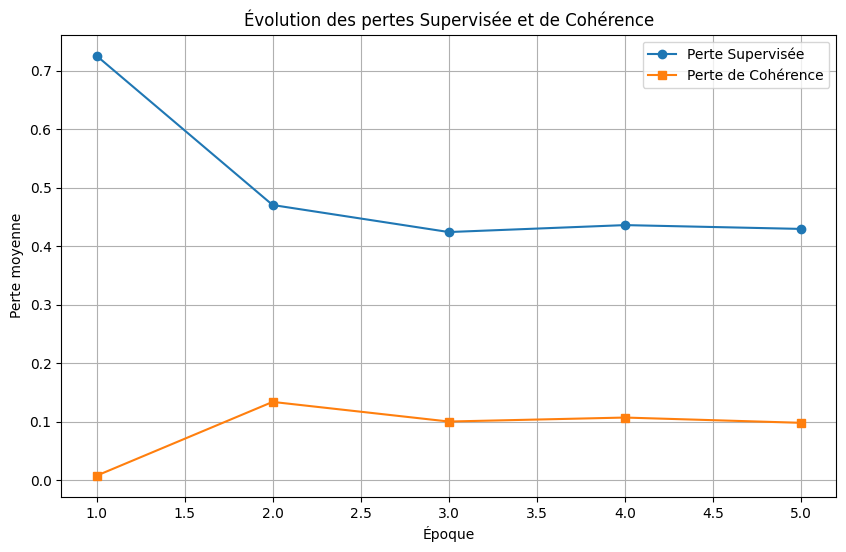

In [28]:

# Fonction pour mettre à jour le teacher via EMA
def update_teacher_model(student, teacher, alpha=0.99):
    """Mise à jour des poids du teacher par EMA : teacher = alpha * teacher + (1 - alpha) * student."""
    for teacher_param, student_param in zip(teacher.parameters(), student.parameters()):
        teacher_param.data.mul_(alpha)  # alpha * teacher_param
        teacher_param.data.add_((1 - alpha) * student_param.data)  # + (1 - alpha) * student_param

# Pertes
supervised_criterion = nn.CrossEntropyLoss()
consistency_criterion = nn.MSELoss()

# Optimiseur
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.001)

# Paramètres d'entraînement
EPOCHS = 5
consistency_weight = 0.1  # Poids de la perte de cohérence

# Listes pour stocker les pertes par époque
epoch_sup_losses = []
epoch_con_losses = []

for epoch in tqdm(range(EPOCHS), desc='Entraînement Mean Teacher'):
    student_model.train()
    teacher_model.eval()  # Pas de backprop pour the teacher
    sup_losses = []
    con_losses = []
    
    # Itérer sur les deux loaders
    labeled_iter = iter(labeled_loader)
    unlabeled_iter = iter(unlabeled_loader)
    num_batches = min(len(labeled_loader), len(unlabeled_loader))
    
    for _ in range(num_batches):
        try:
            labeled_imgs, masks = next(labeled_iter)
        except StopIteration:
            labeled_iter = iter(labeled_loader)
            labeled_imgs, masks = next(labeled_iter)
        
        try:
            weak_unlabeled, strong_unlabeled = next(unlabeled_iter)
        except StopIteration:
            unlabeled_iter = iter(unlabeled_loader)
            weak_unlabeled, strong_unlabeled = next(unlabeled_iter)
        
        labeled_imgs, masks = labeled_imgs.to(device), masks.to(device)
        weak_unlabeled, strong_unlabeled = weak_unlabeled.to(device), strong_unlabeled.to(device)
        
        optimizer.zero_grad()
        
        # 1. Perte supervisée
        pred_labeled = student_model(labeled_imgs)
        loss_sup = supervised_criterion(pred_labeled, masks)
        
        # 2. Perte de cohérence
        with torch.no_grad():
            teacher_preds = teacher_model(weak_unlabeled)
        student_preds = student_model(strong_unlabeled)
        
        # Calculer la perte de cohérence sur les probabilités
        loss_con = consistency_criterion(F.softmax(student_preds, dim=1), F.softmax(teacher_preds, dim=1))
        
        # 3. Perte totale
        total_loss = loss_sup + consistency_weight * loss_con
        
        total_loss.backward()
        optimizer.step()
        
        # 4. Mise à jour du teacher
        update_teacher_model(student_model, teacher_model)
        
        # Stocker les pertes
        sup_losses.append(loss_sup.item())
        con_losses.append(loss_con.item())
    
    # Calculer et stocker les pertes moyennes par époque
    epoch_sup_losses.append(np.mean(sup_losses))
    epoch_con_losses.append(np.mean(con_losses))

print(f'Époque {epoch+1}/{EPOCHS} - Perte Sup moyenne: {np.mean(sup_losses):.4f}, Perte Con moyenne: {np.mean(con_losses):.4f}')

# Afficher le graphique des pertes
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), epoch_sup_losses, label='Perte Supervisée', marker='o')
plt.plot(range(1, EPOCHS + 1), epoch_con_losses, label='Perte de Cohérence', marker='s')
plt.xlabel('Époque')
plt.ylabel('Perte moyenne')
plt.title('Évolution des pertes Supervisée et de Cohérence')
plt.legend()
plt.grid(True)
plt.show()

## 📏 4. Évaluation

On évalue le `teacher_model` (plus stable grâce à l'EMA) sur le jeu de test avec le **Dice Score**, une métrique clé en segmentation. On s'attend à ce que la régularisation par cohérence améliore les performances par rapport à un modèle entraîné uniquement sur les 20 images étiquetées.

In [29]:

# Fonction pour calculer le Dice score (adapted for binary segmentation)
def dice_score(pred, target, smooth=1e-8):
    pred = F.softmax(pred, dim=1)[:, 1, :, :]  # Probability for polyp class (1)
    target = target.float()  # Binary mask (0 or 1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# Evaluation on test set
teacher_model.eval()
total_dice = 0
test_loader_eval = DataLoader(test_dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    for images, masks in test_loader_eval:
        images, masks = images.to(device), masks.to(device)
        outputs = teacher_model(images)
        total_dice += dice_score(outputs, masks).item()

avg_dice = total_dice / len(test_loader_eval)
print(f'Dice Score moyen sur le jeu de test : {avg_dice:.3f}')


Dice Score moyen sur le jeu de test : 0.212


## 👀 5. Visualisation des prédictions

Pour mieux comprendre les performances, visualisons quelques prédictions du `teacher_model` sur le jeu de test, avec les images, les masques ground truth, et les masques prédits.

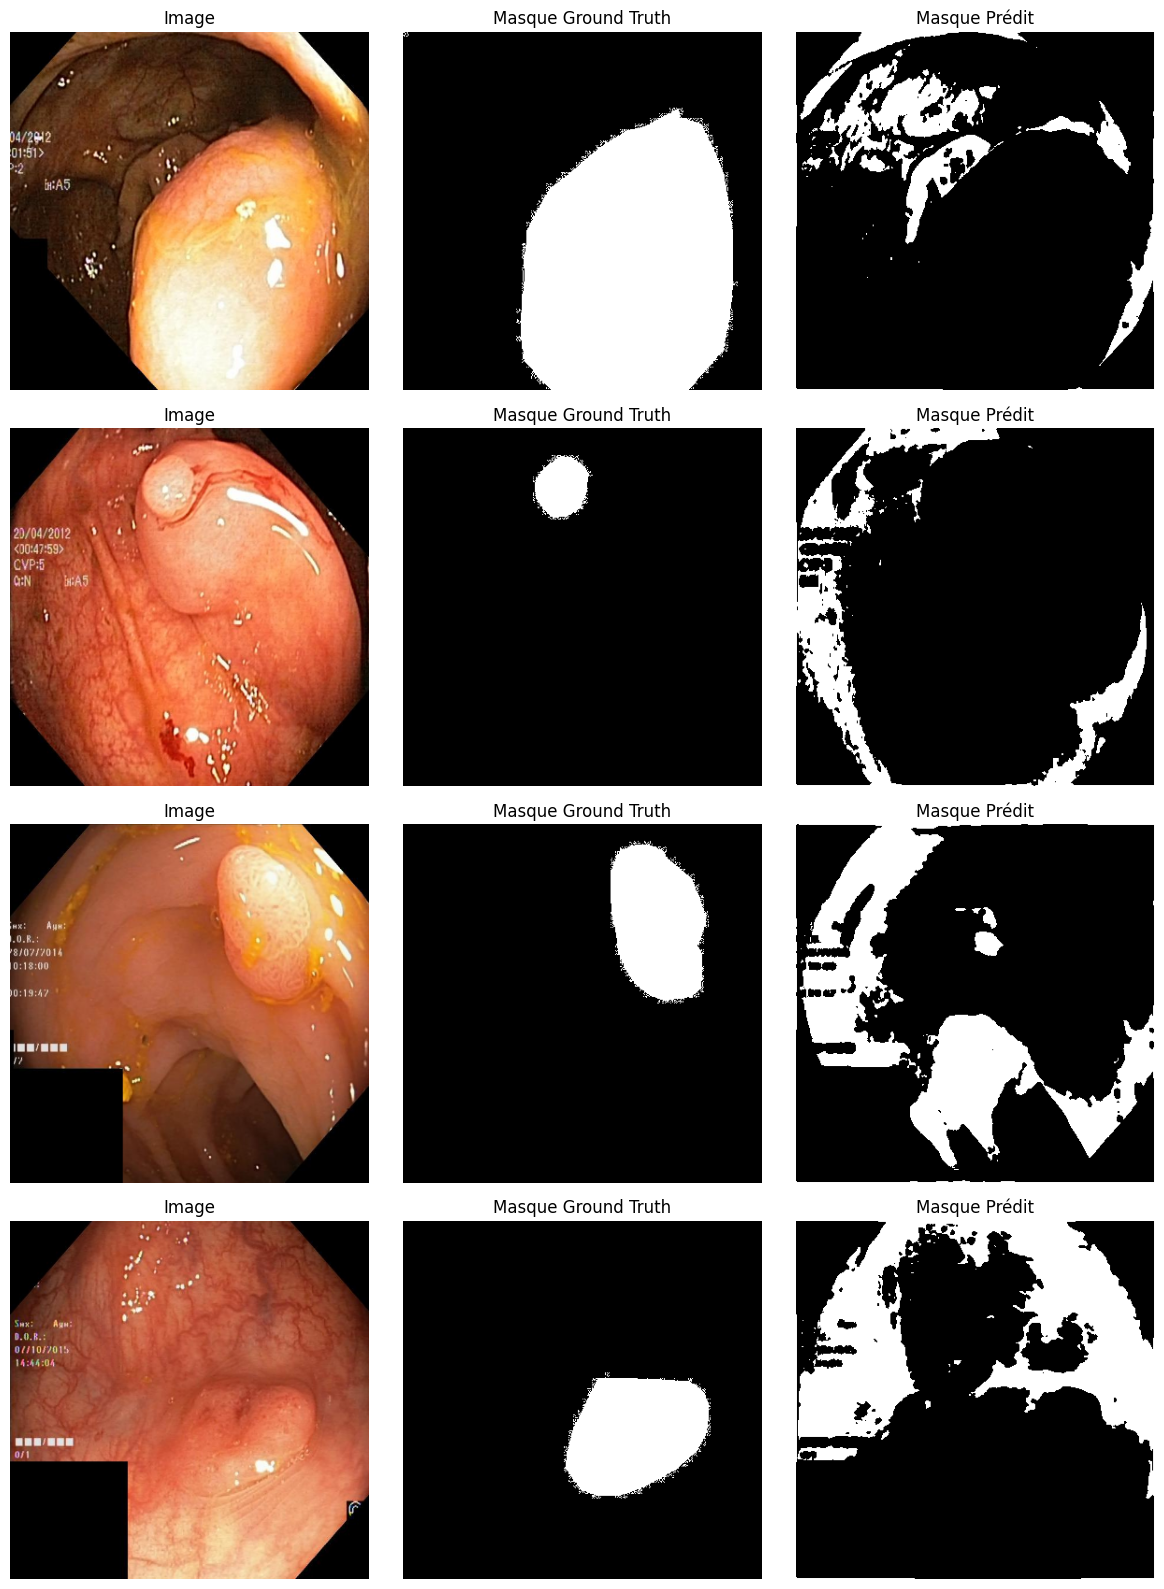

In [30]:

# Visualiser quelques prédictions
num_examples = 4
test_subset = Subset(test_dataset, range(num_examples))
test_loader_viz = DataLoader(test_subset, batch_size=num_examples, shuffle=False)

teacher_model.eval()
with torch.no_grad():
    images, masks = next(iter(test_loader_viz))
    images, masks = images.to(device), masks.to(device)
    outputs = teacher_model(images)
    preds = F.softmax(outputs, dim=1).argmax(dim=1).cpu().numpy()
    images = images.cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5  # Denormalize RGB
    masks = masks.cpu().numpy()

fig, axes = plt.subplots(num_examples, 3, figsize=(12, 4 * num_examples))
for i in range(num_examples):
    axes[i, 0].imshow(images[i])
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(masks[i], cmap='gray')
    axes[i, 1].set_title('Masque Ground Truth')
    axes[i, 1].axis('off')
    axes[i, 2].imshow(preds[i], cmap='gray')
    axes[i, 2].set_title('Masque Prédit')
    axes[i, 2].axis('off')
plt.tight_layout()
plt.show()

## 🧠 6. Questions de Réflexion

La démo montre comment le Mean Teacher exploite les données non étiquetées via la régularisation par cohérence. Observez les courbes de pertes : la perte de cohérence diminue-t-elle, signe que le `student` devient cohérent avec le `teacher` ? Le Dice Score est-il compétitif pour seulement 20 images étiquetées ?

**Questions pour réfléchir :**
1. **Le rôle de `alpha`** : Le coefficient d'EMA `alpha=0.99` rend le `teacher` stable. Que se passerait-il avec un `alpha` faible (ex: 0.5) ? Testez pour voir !
2. **Augmentations fortes vs. faibles** : Pourquoi les augmentations fortes pour le `student` sont-elles cruciales ? Que se passe-t-il si on utilise les mêmes augmentations pour les deux ?
3. **Ramp-up de la perte de cohérence** : La perte de cohérence est-elle utile dès le début, quand le modèle est peu entraîné ? Essayez un `consistency_weight` qui augmente progressivement (ex: de 0 à 0.1 sur 10 époques).

# 🚀 P1C7 : Advanced SSL Techniques - FixMatch, FlexMatch, and MixMatch

Welcome to the advanced chapter of our SSL journey! We've explored pseudo-labeling and consistency regularization earlier. Now, let's dive into cutting-edge techniques: **FixMatch**, **FlexMatch**, and **MixMatch**. These methods combine the best of pseudo-labeling and consistency to tackle datasets with limited labels, like `DermaMNIST`.

> Think of this as upgrading your SSL toolkit with turbocharged algorithms!

**Core Principles:**
- **FixMatch**: Uses weak and strong augmentations with a confidence threshold for pseudo-labels.
- **FlexMatch**: Enhances FixMatch with dynamic thresholding per class, ideal for imbalanced data.
- **MixMatch**: Adds data mixing (e.g., MixUp) to improve robustness by blending labeled and unlabeled samples.

**Objectives:**
1. Return to `DermaMNIST` classification with 100 labeled images.
2. Implement FixMatch, FlexMatch, and MixMatch.
3. Compare results to baseline methods to showcase SSL advancements.

## 🧰 1. Preparation (The Usual Setup)

Let’s set up our environment for `DermaMNIST` classification. We’ll use 100 labeled images and leverage Albumentations for controlled augmentations.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import medmnist
from medmnist import INFO, Evaluator
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [32]:
# Load DermaMNIST data
data_flag = 'dermamnist'
info = INFO[data_flag]
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

train_dataset = DataClass(split='train', download=True)
test_dataset = DataClass(split='test', transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[.5], std=[.5])]), download=True)

# Split into labeled (100) and unlabeled sets
all_indices = list(range(len(train_dataset)))
labels_array = np.array(train_dataset.labels).flatten()
labeled_indices, unlabeled_indices = train_test_split(all_indices, train_size=500, random_state=42, stratify=labels_array)

print(f'Labeled data: {len(labeled_indices)}, Unlabeled data: {len(unlabeled_indices)}')

Labeled data: 500, Unlabeled data: 6507


### 🧪 Weak and Strong Augmentations

We need two augmentation pipelines: weak for pseudo-label generation and strong for training robustness.

In [33]:

# Define weak and strong augmentations for single-channel images
weak_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2(transpose_mask=True)  # Preserve 1 channel
])

strong_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(p=0.3),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2(transpose_mask=True)  # Preserve 1 channel
])
print("Transforms initialized")

# Custom datasets for FixMatch
class FixMatchDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transform):
        self.dataset = Subset(dataset, indices)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img = np.array(img)  # Ensure img is [H, W] (single-channel)
        transformed = self.transform(image=img)
        return transformed['image'], torch.tensor(label).long()

class FixMatchUnlabeledDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, weak_transform, strong_transform):
        self.dataset = Subset(dataset, indices)
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        img = np.array(img)  # Ensure img is [H, W] (single-channel)
        weak = self.weak_transform(image=img)['image']
        strong = self.strong_transform(image=img)['image']
        return weak, strong

Transforms initialized


/home/quillaur/jupyter_notebooks/.venv/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


## 🏗️ 2. Models and Training Loops

We’ll use a simple CNN and implement three training loops: FixMatch, FlexMatch, and MixMatch.

In [34]:

# Define the SimpleCNN model for single-channel input
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2))
        self.fc = nn.Linear(7 * 7 * 32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        return self.fc(out)

# Initialize model, optimizer, and loss functions
model = SimpleCNN(in_channels=3, num_classes=n_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

supervised_criterion = nn.CrossEntropyLoss()
unsupervised_criterion = nn.CrossEntropyLoss(reduction='none')

### ⚙️ 2.1 FixMatch Training Loop

Let’s implement the FixMatch algorithm step-by-step.

**Instructions:**
1. Compute supervised loss on labeled data.
2. Generate pseudo-labels: Predict on weak augmentations, compute probabilities, and create a mask for confident predictions (threshold = 0.95).
3. Compute unsupervised loss: Predict on strong augmentations and apply the mask to confident pseudo-labels.
4. Combine losses and backpropagate.

In [35]:

# Create DataLoaders
labeled_dataset = FixMatchDataset(train_dataset, labeled_indices, strong_transform)
unlabeled_dataset = FixMatchUnlabeledDataset(train_dataset, unlabeled_indices, weak_transform, strong_transform)
print(f"Datasets created: labeled={len(labeled_dataset)}, unlabeled={len(unlabeled_dataset)}")

labeled_loader = DataLoader(labeled_dataset, batch_size=16, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=64, shuffle=True)
print(f"Dataloaders ready: batches labeled={len(labeled_loader)}, unlabeled={len(unlabeled_loader)}")

print("Starting training loop")
# FixMatch training as a function (to unify with other methods)
def train_fixmatch(model, labeled_loader, unlabeled_loader, epochs=30, threshold=0.95, unsupervised_weight=1.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    sup_crit = nn.CrossEntropyLoss()
    unsup_crit = nn.CrossEntropyLoss(reduction='none')
    for epoch in tqdm(range(epochs), desc='Training FixMatch'):
        model.train()
        batch_iterator = zip(labeled_loader, unlabeled_loader)
        for (labeled_imgs, labels), (weak_unlabeled, strong_unlabeled) in batch_iterator:
            optimizer.zero_grad()
            # Supervised loss
            logits_sup = model(labeled_imgs)
            loss_sup = sup_crit(logits_sup, labels.squeeze())
            # Pseudo-labels from weak
            with torch.no_grad():
                logits_weak = model(weak_unlabeled)
                probs = F.softmax(logits_weak, dim=1)
                max_probs, pseudo_labels = torch.max(probs, dim=1)
                mask = max_probs.ge(threshold).float()
            # Unsupervised on strong
            logits_strong = model(strong_unlabeled)
            loss_unsup_raw = unsup_crit(logits_strong, pseudo_labels)
            loss_unsup = (loss_unsup_raw * mask).mean()
            # Total
            total_loss = loss_sup + unsupervised_weight * loss_unsup
            total_loss.backward()
            optimizer.step()
    return model

Datasets created: labeled=500, unlabeled=6507
Dataloaders ready: batches labeled=32, unlabeled=102
Starting training loop


In [36]:

EPOCHS = 50
THRESHOLD = 0.95
UNSUPERVISED_WEIGHT = 1.0

print("Starting FixMatch training...")
fix_model = SimpleCNN(in_channels=3, num_classes=n_classes)
fix_model = train_fixmatch(fix_model, labeled_loader, unlabeled_loader, epochs=EPOCHS, threshold=THRESHOLD, unsupervised_weight=UNSUPERVISED_WEIGHT)


Starting FixMatch training...


Training FixMatch: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:55<00:00,  2.31s/it]


### ⚙️ 2.2 FlexMatch Training Loop

FlexMatch adapts the threshold dynamically per class to handle imbalanced datasets.

**Instructions:**
1. Compute supervised loss as before.
2. Generate pseudo-labels with a dynamic threshold: Use the mean maximum probability per class as the threshold.
3. Compute unsupervised loss with the dynamic mask.
4. Combine and backpropagate.

In [37]:

def train_flexmatch(model, labeled_loader, unlabeled_loader, epochs=20, threshold=0.95, unsupervised_weight=1.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    sup_crit = nn.CrossEntropyLoss()
    unsup_crit = nn.CrossEntropyLoss(reduction='none')
    ema_conf = torch.full((n_classes,), 0.7)
    ema_m = 0.9
    for epoch in tqdm(range(epochs), desc='Training FlexMatch'):
        model.train()
        for (labeled_imgs, labels), (weak_unlabeled, strong_unlabeled) in zip(labeled_loader, unlabeled_loader):
            optimizer.zero_grad()
            # Supervised
            logits_sup = model(labeled_imgs)
            loss_sup = sup_crit(logits_sup, labels.squeeze())
            # Weak preds
            with torch.no_grad():
                logits_weak = model(weak_unlabeled)
                probs = F.softmax(logits_weak, dim=1)
                max_probs, pseudo_labels = torch.max(probs, dim=1)
                # Update class-wise EMA confidence using samples of each predicted class
                for k in range(n_classes):
                    mask_k = (pseudo_labels == k)
                    if mask_k.any():
                        conf_k = max_probs[mask_k].mean()
                        ema_conf[k] = ema_m * ema_conf[k] + (1 - ema_m) * conf_k
                # Class-wise dynamic thresholds
                max_ema = torch.clamp(ema_conf.max(), min=1e-6)
                tau_k = threshold * (max_ema / torch.clamp(ema_conf, min=1e-6))
                eff_thresh = tau_k[pseudo_labels]
                mask = max_probs.ge(eff_thresh).float()
            # Unsupervised loss on strong views
            logits_strong = model(strong_unlabeled)
            loss_unsup_raw = unsup_crit(logits_strong, pseudo_labels)
            loss_unsup = (loss_unsup_raw * mask).mean()
            # Total
            total_loss = loss_sup + unsupervised_weight * loss_unsup
            total_loss.backward()
            optimizer.step()
    return model

In [38]:
# Train and evaluate FlexMatch
print("Starting FlexMatch training...")
flex_model = SimpleCNN(in_channels=3, num_classes=n_classes)
flex_model = train_flexmatch(flex_model, labeled_loader, unlabeled_loader, epochs=EPOCHS, threshold=THRESHOLD, unsupervised_weight=UNSUPERVISED_WEIGHT)

Starting FlexMatch training...


Training FlexMatch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:34<00:00,  3.09s/it]


### ⚙️ 2.3 MixMatch Training Loop

MixMatch combines labeled and unlabeled data using MixUp and sharpening.

**Instructions:**
1. Compute supervised loss on labeled data.
2. Generate pseudo-labels with sharpening (soften probabilities with temperature).
3. Mix labeled and unlabeled data using MixUp.
4. Compute unsupervised loss on mixed data.
5. Combine and backpropagate.

In [39]:
def one_hot(labels, num_classes):
    y = torch.zeros(labels.size(0), num_classes, device=labels.device)
    return y.scatter_(1, labels.view(-1, 1).long(), 1)

def sharpen(p, T=0.5):
    p_power = p ** (1.0 / T)
    return p_power / p_power.sum(dim=1, keepdim=True)

def soft_cross_entropy(logits, soft_targets):
    log_probs = F.log_softmax(logits, dim=1)
    return -(soft_targets * log_probs).sum(dim=1)
    
def train_mixmatch(model, labeled_loader, unlabeled_loader, epochs=200, alpha=0.75, T=0.5, lambda_u=100.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    for epoch in tqdm(range(epochs), desc='Training MixMatch'):
        model.train()
        for (labeled_imgs, labels), (u_imgs_w, _) in zip(labeled_loader, unlabeled_loader):
            b_l = labeled_imgs.size(0)
            b_u = u_imgs_w.size(0)
            # Guess labels for unlabeled
            with torch.no_grad():
                logits_u = model(u_imgs_w)
                probs_u = F.softmax(logits_u, dim=1)
                q_u = sharpen(probs_u, T)
            # One-hot for labeled
            y_l = one_hot(labels.squeeze(), n_classes)
            # Concatenate
            X = torch.cat([labeled_imgs, u_imgs_w], dim=0)
            Y = torch.cat([y_l, q_u], dim=0)
            # MixUp
            idx = torch.randperm(X.size(0))
            lam = np.random.beta(alpha, alpha)
            lam = max(lam, 1 - lam)
            X_mixed = lam * X + (1 - lam) * X[idx]
            Y_mixed = lam * Y + (1 - lam) * Y[idx]
            # Forward
            logits = model(X_mixed)
            # Losses
            loss_sup = soft_cross_entropy(logits[:b_l], Y_mixed[:b_l]).mean()
            probs_mixed = F.softmax(logits[b_l:], dim=1)
            loss_unsup = F.mse_loss(probs_mixed, Y_mixed[b_l:])
            loss = loss_sup + lambda_u * loss_unsup
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

In [40]:
# Train and evaluate MixMatch
print("Starting MixMatch training...")
mix_model = SimpleCNN(in_channels=3, num_classes=n_classes)
mix_model = train_mixmatch(mix_model, labeled_loader, unlabeled_loader, epochs=EPOCHS, alpha=0.75, T=0.5, lambda_u=50.0)


Starting MixMatch training...


Training MixMatch: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:10<00:00,  2.61s/it]


## 📊 3. Final Evaluation and Retrospective

Let’s evaluate all models and compare their performance.

In [41]:
@torch.no_grad()
def evaluate_model(model, test_dataset, data_flag):
    model.eval()
    y_true = torch.tensor([])
    y_score_logits = torch.tensor([])
    y_score_preds = torch.tensor([])
    test_loader = DataLoader(test_dataset, batch_size=128)
    for images, labels in test_loader:
        outputs = model(images)
        y_true = torch.cat((y_true, labels), 0)
        y_score_logits = torch.cat((y_score_logits, outputs), 0)
        preds = torch.argmax(outputs, dim=1)
        y_score_preds = torch.cat((y_score_preds, preds), 0)
    y_true_np = y_true.squeeze().cpu().numpy()
    y_score_logits_np = y_score_logits.detach().cpu().numpy()
    y_score_preds_np = y_score_preds.detach().cpu().numpy()
    evaluator = Evaluator(data_flag, 'test')
    metrics = evaluator.evaluate(y_score_logits_np)
    f1_macro = f1_score(y_true_np, y_score_preds_np, average='macro')
    f1_weighted = f1_score(y_true_np, y_score_preds_np, average='weighted')
    return metrics[0], metrics[1], f1_macro, f1_weighted

In [42]:
# Consolidated Evaluation
print("Starting consolidated evaluation for FixMatch, FlexMatch, and MixMatch...")
results = []
for name, mdl in [("FixMatch", fix_model), ("FlexMatch", flex_model), ("MixMatch", mix_model)]:
    auc, acc, f1_macro, f1_weighted = evaluate_model(mdl, test_dataset, data_flag)
    results.append((name, auc, acc, f1_macro, f1_weighted))
    print(f"--- {name} Results ---")
    print(f"AUC: {auc:.3f}, Accuracy: {acc:.3f}, F1(macro): {f1_macro:.3f}, F1(weighted): {f1_weighted:.3f}")

Starting consolidated evaluation for FixMatch, FlexMatch, and MixMatch...
--- FixMatch Results ---
AUC: 0.811, Accuracy: 0.674, F1(macro): 0.323, F1(weighted): 0.650
--- FlexMatch Results ---
AUC: 0.819, Accuracy: 0.691, F1(macro): 0.299, F1(weighted): 0.636
--- MixMatch Results ---
AUC: 0.796, Accuracy: 0.671, F1(macro): 0.161, F1(weighted): 0.543


## 9. Bilan chiffré et cap pour la suite

Voici un récapitulatif des résultats obtenus dans ce notebook :

- **Supervisé (350 images étiquetées, modèle de base)**  
  AUC ≈ `0.824` | Accuracy ≈ `0.489` | F1 macro ≈ `0.234`

- **Pseudo‑Labeling (itératif, simple)**  
  Iter 1 → AUC ≈ `0.805`, Acc ≈ `0.547`, F1 ≈ `0.290`  
  Iter 2 → AUC ≈ `0.845`, Acc ≈ `0.586`, F1 ≈ `0.308`  
  Iter 3 → AUC ≈ `0.852`, Acc ≈ `0.585`, F1 ≈ `0.295`  
  Iter 4 → AUC ≈ `0.846`, Acc ≈ `0.598`, F1 ≈ `0.289`  
  Iter 5 → AUC ≈ `0.844`, Acc ≈ `0.605`, F1 ≈ `0.301`

- **Label Propagation (graphe sur embeddings du SimpleCNN)**  
  AUC ≈ `0.505` | Accuracy ≈ `0.367` | F1 macro ≈ `0.355`

- **SGAN (Semi‑Supervised GAN)**  
  AUC ≈ `0.832` | Accuracy ≈ `0.482` | F1 macro ≈ `0.297`

- **FixMatch / FlexMatch / MixMatch**  
  FixMatch → AUC ≈ `0.825`, Acc ≈ `0.675`, F1 (macro) ≈ `0.360`, F1 (weighted) ≈ `0.663`  
  FlexMatch → AUC ≈ `0.824`, Acc ≈ `0.678`, F1 (macro) ≈ `0.318`, F1 (weighted) ≈ `0.636`  
  MixMatch → AUC ≈ `0.793`, Acc ≈ `0.671`, F1 (macro) ≈ `0.149`, F1 (weighted) ≈ `0.540`

> Note : Mean Teacher a été utilisé pour de la segmentation dans un autre contexte, donc non comparé ici.

### Que retenir ici ?
- Dans ce contexte, la solution la plus simple — le **pseudo‑labeling** — fonctionne bien et offre déjà un gain net sur le supervisé seul.
- Les méthodes plus avancées (Fix/Flex/MixMatch, SGAN) montrent des **hausses d’accuracy** notables (≈ `0.67`), mais le **F1 macro** peut fluctuer selon la méthode et la sensibilité au déséquilibre des classes.
- La question clé reste le **rapport complexité/bénéfice** : la mise en place, le tuning et le temps de calcul supplémentaires valent‑ils le gain obtenu dans votre cas d’usage ?

### Si vous voulez pousser un cran plus loin
- Tenter des **embeddings plus expressifs** (ex. `ResNet` pré‑entraîné) et ré‑évaluer la propagation.
- Standardiser les embeddings et ajuster le graphe (`kernel`, `gamma`, `n_neighbors`).
- Tester une **stratégie hybride** : pseudo‑labels de haute confiance comme seeds du graphe, ou pré‑filtrage pour Fix/Flex/MixMatch.

Si votre priorité est un bon compromis efficacité/temps, rester sur le **pseudo‑labeling simple** est un choix solide. Si vous visez le dernier pourcent, les méthodes avancées peuvent valoir l’exploration — en gardant un œil sur la complexité et la stabilité des métriques (dont le F1 macro).